In [1]:
import os
import pickle
import numpy as np
from scipy.signal import savgol_filter
from kneebow.rotor import Rotor
import matplotlib.pyplot as plt
#plt.style.use(['science','notebook'])
plt.style.use(["seaborn"])

#TITLE_SIZE=48
#TICK_SIZE=38
#TICK_LABEL_SIZE=42
#TEXT_SIZE=40
TITLE_SIZE=12
TICK_SIZE=18
TICK_LABEL_SIZE=28
TEXT_SIZE=30

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": TICK_LABEL_SIZE,
    "font.size": TEXT_SIZE,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": TICK_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE, 
    "axes.titlesize": TITLE_SIZE
}


plt.rcParams.update(tex_fonts)
from plottify import autosize


/tmp/ipykernel_3732446/366873851.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn"])


In [2]:
# !pip3 install kneebow

In [3]:
base_dir = "/home/coppolillo/Desktop/RVAE/"
data_dir = os.path.join(base_dir, "data")
datasets = [elem for elem in os.listdir(data_dir) if not elem.startswith(".")]
figures_dir = os.path.join(os.getcwd(), "figures")

print(figures_dir)
pdf_dir = os.path.join(figures_dir, "pdf")
png_dir = os.path.join(figures_dir, "png")
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
if not os.path.exists(pdf_dir):
    os.makedirs(pdf_dir)
if not os.path.exists(png_dir):
    os.makedirs(png_dir)
datasets

/home/coppolillo/Desktop/RVAE/rvae/figures


['bpr_best_ensemble_delta.csv',
 'yahoo-r3',
 'pinterest',
 'ml-1m',
 'overleaf_rvae_global_low_test_results.txt',
 'overleaf_bpr_table_test_results.txt',
 'overleaf_bpr_global_low_test_results.txt',
 'overleaf_rvae_heatmap_test_results.txt',
 'amzn-ggf',
 'rvae_best_ensemble_delta.csv',
 'overleaf_bpr_heatmap_test_results.txt',
 'citeulike-a',
 'overleaf_rvae_table_test_results.txt']

In [4]:
titles={"citeulike-a":"Citeulike-a", 
        "ml-1m": "MovieLens-1M",  
         "pinterest":"Pinterest", 
        "yahoo-r3": "Yahoo-r3", 
       "amzn-ggf":"Amazon-GGF"}

In [5]:
IDX=3
# 0 1 4 6
    
with open(os.path.join(data_dir, datasets[IDX], "data_bpr.pickle"), "rb") as f:
    data = pickle.load(f)
nusers = data["users"] # len(data["training_data"])
f = data["popularity"] # data["popularity_dict"]["training"]
thresholds = data["thresholds"]
print(f"n items: {data['items']}")
print(f"squared root of nitems: {data['items']**0.5}")
f = list(map(lambda x:round(x*nusers) if "ml-20m" in datasets[IDX] else x*nusers, f))
thresholds = list(map(lambda x:x*nusers, thresholds))



n items: 3462
squared root of nitems: 58.8387627334226


In [6]:
datasets[IDX]

'ml-1m'

In [7]:
def find_elbow(data):
    rotor = Rotor()
    rotor.fit_rotate(data)

    return rotor.get_elbow_index()


def get_thresholds(x, y):
    # smoothing the curve
    window_size = max(5, len(y) // 5)
    
    polynomial_order = 2
    smoothed_y = savgol_filter(y, window_size, polynomial_order)
    
#     smoothed_model = np.poly1d(np.polyfit(x, y, ))
#     smoothed_y = smoothed_model(x)
    
    # computing derivatives
    y1 = np.diff(smoothed_y) / np.diff(x)
    y2 = np.diff(y1) / np.diff(x)[:-1]
    
    # searching the inflection point
    idx = np.abs(y2).argmin()
    
#     print(idx)

    left_x = x[:idx]
    left_y = smoothed_y[:idx]
    
    left_elbow = find_elbow(np.array(list(zip(left_x, -left_y))))

    right_x = x[idx:]
    right_y = smoothed_y[idx:]
    
    right_elbow = find_elbow(np.array(list(zip(right_x, right_y))))

    low_thr_x = x[left_elbow]
    low_thr_y = y[left_elbow]

    high_thr_x = x[right_elbow + idx]
    high_thr_y = y[right_elbow + idx]
        

    return (low_thr_x, low_thr_y), (high_thr_x, high_thr_y)

In [8]:


x = list(range(len(f)))
y = sorted(f)


ts = get_thresholds(x, y)

(low_thr_x, low_thr_y), (high_thr_x, high_thr_y) = ts

In [20]:
computed_thresholds = [low_thr_y/nusers, high_thr_y/nusers]
data["thresholds"] = computed_thresholds

In [21]:
import pickle 
with open(os.path.join("../data", datasets[IDX], "data_bpr.pickle"), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

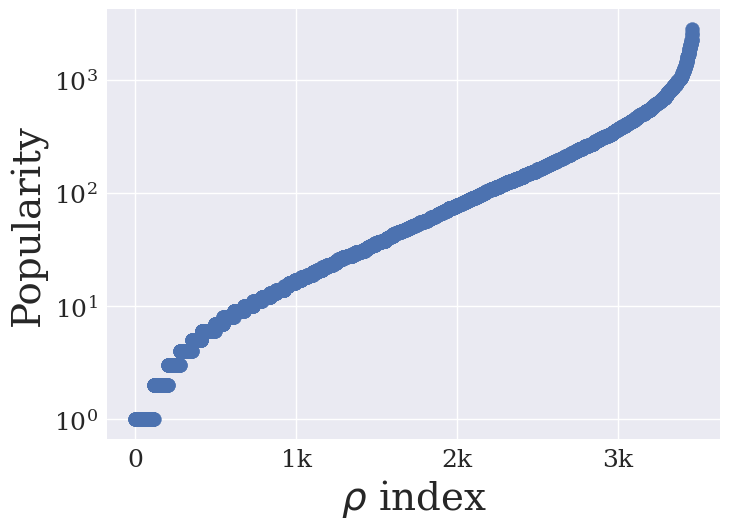

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

# s = np.repeat(1, len(x))
ax.scatter(x, y, s=100)

linewidth = 5

#plt.vlines(low_thr_x, min(y), low_thr_y, linestyles='dashed', alpha=1, color='black', label=r"low-popular", linewidth=linewidth)
#plt.hlines(low_thr_y, min(x), low_thr_x, linestyles='dashed', alpha=1, color='black', linewidth=linewidth)
#plt.vlines(high_thr_x, min(y), high_thr_y, linestyles='dashed', alpha=1, color='red', label=r"high-popular", linewidth=linewidth)
#plt.hlines(high_thr_y, min(x), high_thr_x, linestyles='dashed', alpha=1, color='red', linewidth=linewidth)

if "citeulike" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,16001,4000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 17, 4)])
elif "pinterest" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,10001,2000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 11, 2)])
elif "amzn" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,23001,4000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 23, 4)])
elif "ml-1m" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,3501,1000),labels=[f"{num}k" if num!=0 else "0" for num in range(0,4,1)])
elif "ml-20m" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,20001,5000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 21, 5)])
elif "epinions" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,500001,125000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 501, 125)])
elif "netflix" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,15001,5000),labels=[f"{num}k" if num!=0 else "0" for num in np.arange(0, 16, 5)])
elif "yahoo" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,1001,250),labels=["0", "250", "500", "750", "1k"])
    
#ax.set_title(titles[datasets[IDX]])

ax.set_xlabel(r"$\rho$ index")
ax.set_ylabel("Popularity")

ax.set_yscale("log")

#autosize()
if "citeulike-a" in datasets[IDX]:
    ax.legend(fontsize=25)
    
fig.tight_layout()
# ax.grid()
# ax.set_facecolor("white")

# SI VOLA

fig.savefig(os.path.join(pdf_dir, f"item_pop_{datasets[IDX]}_without_thresholds.pdf"))
fig.savefig(os.path.join(png_dir, f"item_pop_{datasets[IDX]}_without_thresholds.png"), dpi=300)

In [42]:
a = np.array(x)
b = np.array(y)
len(a[b == 1.0])

116

In [ ]:
frequencies = np.cumsum(to_plot[:, 1][::-1])[::-1]

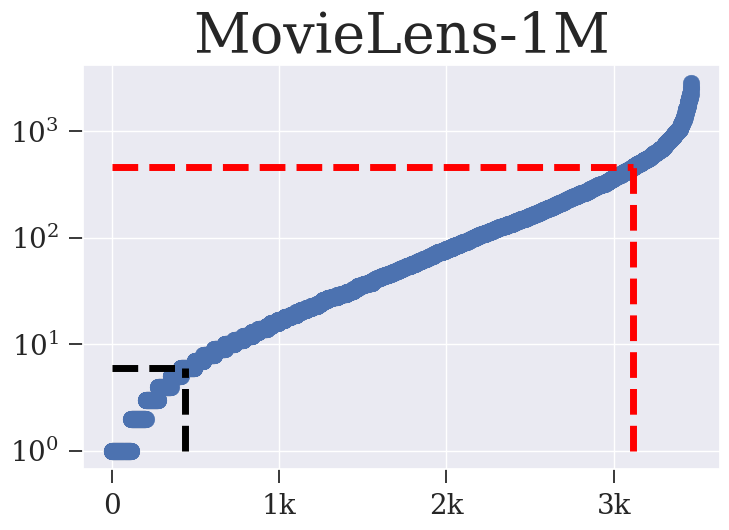

In [45]:
fig, ax = plt.subplots(figsize=(8,6))

# s = np.repeat(1, len(x))
ax.scatter(x, y, s=20)

linewidth = 5

plt.vlines(low_thr_x, min(y), low_thr_y, linestyles='dashed', alpha=1, color='black', label=r"low-popular", linewidth=linewidth)
plt.hlines(low_thr_y, min(x), low_thr_x, linestyles='dashed', alpha=1, color='black', linewidth=linewidth)
plt.vlines(high_thr_x, min(y), high_thr_y, linestyles='dashed', alpha=1, color='red', label=r"high-popular", linewidth=linewidth)
plt.hlines(high_thr_y, min(x), high_thr_x, linestyles='dashed', alpha=1, color='red', linewidth=linewidth)

if "citeulike" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,16001,4000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 17, 4)])
elif "pinterest" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,10001,2000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 11, 2)])
elif "amzn" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,23001,4000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 23, 4)])
elif "ml-1m" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,3501,1000),labels=[f"{num}k" if num!=0 else "0" for num in range(0,4,1)])
elif "ml-20m" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,20001,5000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 21, 5)])
elif "epinions" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,500001,125000),labels=[f"{num}k" if num!=0 else "0" for num in range(0, 501, 125)])
elif "netflix" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,15001,5000),labels=[f"{num}k" if num!=0 else "0" for num in np.arange(0, 16, 5)])
elif "yahoo" in datasets[IDX]:
    plt.xticks(ticks=np.arange(0,1001,250),labels=["0", "250", "500", "750", "1k"])
    
ax.set_title(titles[datasets[IDX]])

ax.set_yscale("log")

autosize()
if "citeulike-a" in datasets[IDX]:
    ax.legend(fontsize=25)
    
fig.tight_layout()
# ax.grid()
# ax.set_facecolor("white")

# SI VOLA

#fig.savefig(os.path.join(pdf_dir, f"item_pop_{datasets[IDX]}.pdf"))
#fig.savefig(os.path.join(png_dir, f"item_pop_{datasets[IDX]}.png"), dpi=300)

In [58]:
np.where(np.array(sorted(f))==285)

(array([905, 906]),)

In [57]:
th_high

285

In [59]:
905/len(f)

0.9282051282051282

In [28]:
len(f)

21800